In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df = pd.read_csv('algerian.txt' ,header=None)

cols = ['year', 'value']

# insert a column with values starting from 1960
df.insert(0, 'year', range(1960, 1960 + len(df)))
df.columns = cols
# plot the data nased on the year and the value
# plt.plot(df['year'], df['value'])
df[f'time'] = pd.to_datetime(df['year'],  format='%Y')
df.drop('year', axis=1, inplace=True)
df.set_index('time', inplace=True)




In [ ]:
def single_exp_smoothing(y, alpha: float) -> float:
    y_hat = [y.iloc[0]] # first value is same as series
    for i in range(1, len(y)):
        y_hat.append(alpha * y.iloc[i] + (1 - alpha) * y_hat[i-1])
    return y_hat

def sse(actual:list[float], predicted: list[float]) -> float:
    return sum((actual - predicted) ** 2)

def find_best_alpha(y:list[float], alphas: list[float]) -> float:

    best_alpha = None
    best_sse = None
    predictions = None
    for alpha in alphas:
        predictions = single_exp_smoothing(y, alpha)
        sse_value = sse(y, predictions)
        if best_sse is None or sse_value < best_sse:
            best_sse = sse_value
            best_alpha = alpha
    return best_alpha, best_sse, predictions


In [ ]:
# Set the frequency of the time series
df = df.asfreq('YS')

# Split the data into training and testing data
train = df.iloc[:int(len(df)*0.5)]
test = df.iloc[int(len(df)*0.5):]


# apply ses
alpha, best_sse, predictions = find_best_alpha(train['value'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
print(f'Best alpha: {alpha}')
print(f'Best SSE: {best_sse}')

# plot predictions, test and train on same plot
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
# create df with the predictions as values and same datetime as the test
predictions = pd.DataFrame(predictions, index=test.index, columns=['value'])

plt.plot(predictions['value'], label='SES')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing applied to algerian export')
plt.show()


In [ ]:
# now i will apply better aplha search using simple function
# Set the frequency of the time series
def generate_alpha_values(start: float, end: float, step: float) -> list[float]:
    return [round(x, 3) for x in np.arange(start, end, step)]

alpha, best_sse, predictions = find_best_alpha(train['value'], generate_alpha_values(0.001, 0.999, 0.001))
print(f'Best alpha: {alpha}')
print(f'Best SSE: {best_sse}')

# plot predictions, test and train on same plot
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
# create df with the predictions as values and same datetime as the test
predictions = pd.DataFrame(predictions, index=test.index, columns=['value'])

plt.plot(predictions['value'], label='SES')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing applied to algerian export')
plt.show()

In [ ]:
def calculate_forecasts_and_sse(y, alpha):
    y_hat = [y[0]]  # initial forecast is the first observation
    for t in range(1, len(y)):
        y_hat.append(alpha * y[t-1] + (1 - alpha) * y_hat[t-1])
    residuals = [(y[t] - y_hat[t]) ** 2 for t in range(len(y))]
    sse = sum(residuals)
    return y_hat, sse



In [ ]:
# Generate a list of alpha values between 0 and 1
alphas = np.linspace(0, 1, 100)

best_alpha = None
best_sse = None
best_forecasts = None

# For each alpha value, calculate the forecasts and SSE
for alpha in alphas:
    forecasts, sse = calculate_forecasts_and_sse(train['value'], alpha)
    if best_sse is None or sse < best_sse:
        best_sse = sse
        best_alpha = alpha
        best_forecasts = forecasts

print(f'Best alpha: {best_alpha}')
print(f'Best SSE: {best_sse}')

# Plot the training and testing set, fitted values, and the forecast
plt.figure(figsize=(10, 6))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(pd.date_range(start=train.index[0], periods=len(best_forecasts), freq='YS'), best_forecasts, label='SES')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing applied to Algerian export')
plt.show()

# New idea, create new pipeline with proper SES method


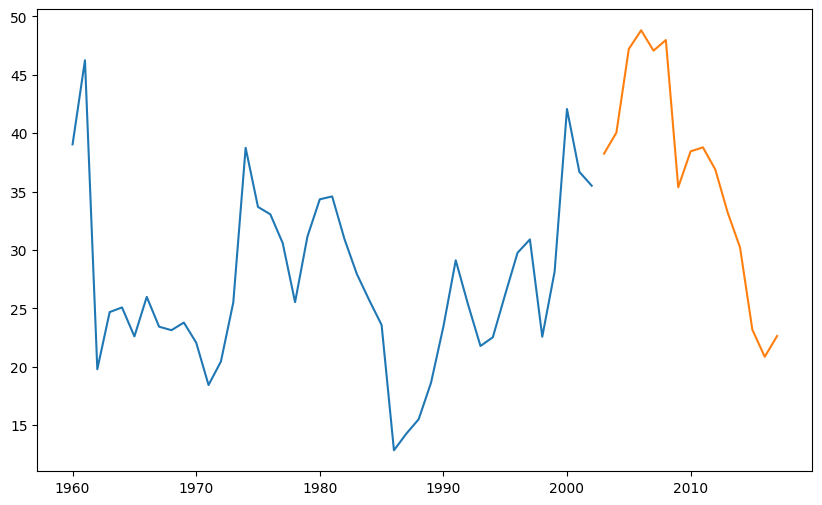

In [35]:
alpha: float = 0.5
# y_hat t+1|1 = alpha * y + (1 - alpha) * y_hat t|t-1
# create a function based on this

train_set = df.iloc[:int(len(df)*0.7)]
test_set = df.iloc[int(len(df)*0.7):]

plt.figure(figsize=(10, 6))
plt.plot(train_set['value'], label='Train')
plt.plot(test_set['value'], label='Test')
